### Problem description: https://www.kaggle.com/c/statoil-iceberg-classifier-challenge#background
#### Project starting date： 11-1-2017

#### Data Description:
The data (train.json, test.json) is presented in json format. The files consist of a list of images, and for each image, you can find the following fields:

id - the id of the image

band_1, band_2 - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.

--  in optics, dB generally represent ratios of digitized light levels
inc_angle - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.

is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.

#### Evaluation: LogLoss
https://www.kaggle.com/wiki/LogLoss


### 1. Import data

#### As usual, we first import some packages.

In [1]:
%matplotlib inline
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Both the training and testing dataset are in json format, so we open them with pandas read_json module. The train and test dataset are stored as pandas dataframe.

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

### 2. Summary of Data
#### Next, let's get some general information especially the type and the size of the training and testing dataset.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 263.3+ KB


In [5]:
train.head(5)

band_1  \
0  [-27.878360999999998, -27.15416, -28.668615, -...   
1  [-12.242375, -14.920304999999999, -14.920363, ...   
2  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2        id inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913   43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd   38.1562   
2  [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0   45.2859   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18   43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4   35.6256   

   is_iceberg  
0           0  
1           0  
2           1  
3           0  
4           0

In [6]:
test.head(5)

band_1  \
0  [-15.863251, -15.201077, -17.887735, -19.17248...   
1  [-26.058969497680664, -26.058969497680664, -26...   
2  [-14.14109992980957, -15.064241409301758, -17....   
3  [-12.167478, -13.706167, -16.54837, -13.572674...   
4  [-23.37459373474121, -26.02718162536621, -28.1...   

                                              band_2        id  inc_angle  
0  [-21.629612, -21.142353, -23.908337, -28.34524...  5941774d  34.966400  
1  [-25.754207611083984, -25.754207611083984, -25...  4023181e  32.615072  
2  [-14.74563980102539, -14.590410232543945, -14....  b20200e4  37.505433  
3  [-24.32222, -26.375538, -24.096739, -23.8769, ...  e7f018bb  34.473900  
4  [-25.72234344482422, -27.011577606201172, -23....  4371c8c3  43.918874

#### We noticed that inc_angle in the training dataset has NA values, let's take rows containing NA values out for simplicity of visualization for now. We can do other processing of the NA values later when needed.

In [7]:
train['inc_angle'].describe()

count     1604
unique     879
top         na
freq       133
Name: inc_angle, dtype: object

In [8]:
train[train['inc_angle'] != 'na']['inc_angle'].count()
train = train[train['inc_angle'] != 'na']

In [9]:
train['inc_angle'].describe()

count     1471.0000
unique     878.0000
top         34.4721
freq        23.0000
Name: inc_angle, dtype: float64

In [10]:
test['inc_angle'].describe()

count    8424.000000
mean       40.153403
std         4.108386
min        23.080500
25%        36.905200
50%        40.375790
75%        43.472950
max        50.661785
Name: inc_angle, dtype: float64

### 3. Data Visualization

#### 3.1 Let's first visualize the distribution of the inc_angle in both train and test dataset. We noticed that both dataset has quite similar range and distribution. This may make our life easier.

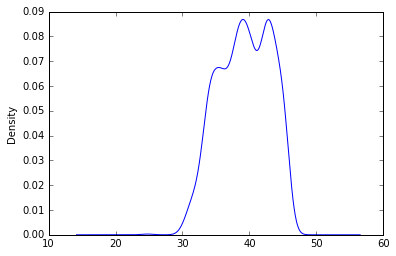

In [11]:
# plot inc_angle in training set
train['inc_angle'].plot(logx = False, logy = False, kind = 'kde')
plt.show()

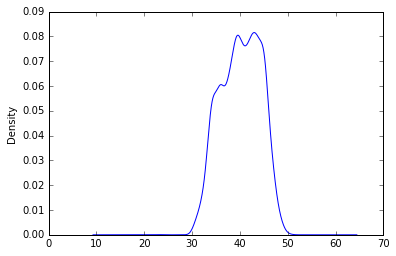

In [12]:
# plot inc_angle in testing set
test['inc_angle'].plot(logx = False, logy = False, kind = 'kde')
plt.show()

#### 3.2 Let's visualize the images without any processing.

In [13]:
# reshape data into images
train = train.dropna(axis = 0, how = 'any') 
train = train.set_index([[i for i in range(1471)]]) 

train['band_1'] = train['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
train['band_2'] = train['band_2'].apply(lambda x: np.array(x).reshape(75, 75))

#  -1 means it is an unknown dimension and we want numpy to figure it out
band_1 = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2 = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
full_img = np.stack([band_1, band_2], axis=1)

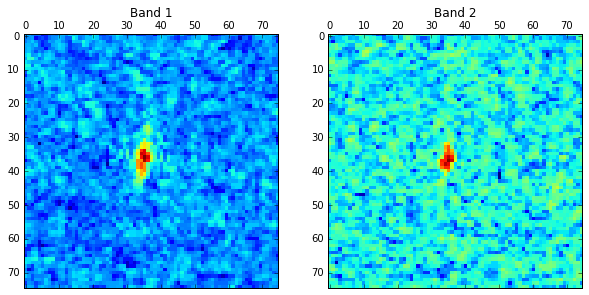

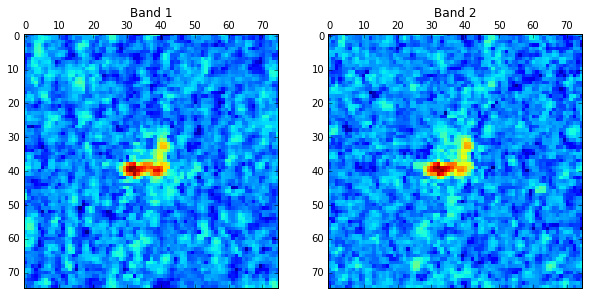

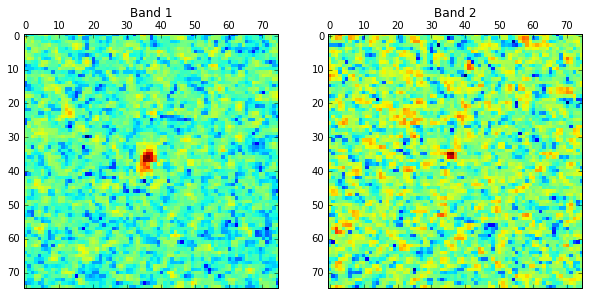

In [14]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.matshow(full_img[i, 0, :, :])
    ax1.set_title('Band 1')
    ax2.matshow(full_img[i, 1, :, :])
    ax2.set_title('Band 2')

We can tell there's no intuitive relationship between images from band_1 and band_2 for the same object.

Let's plot some iceberg images and some boat images to see whether there's any trend.

In [15]:
icebergs = train[train.is_iceberg == 1].sample(n = 6,random_state = 9)
ships = train[train.is_iceberg == 0].sample(n = 6,random_state = 9)

The first set show 6 random icebergs using band 1.

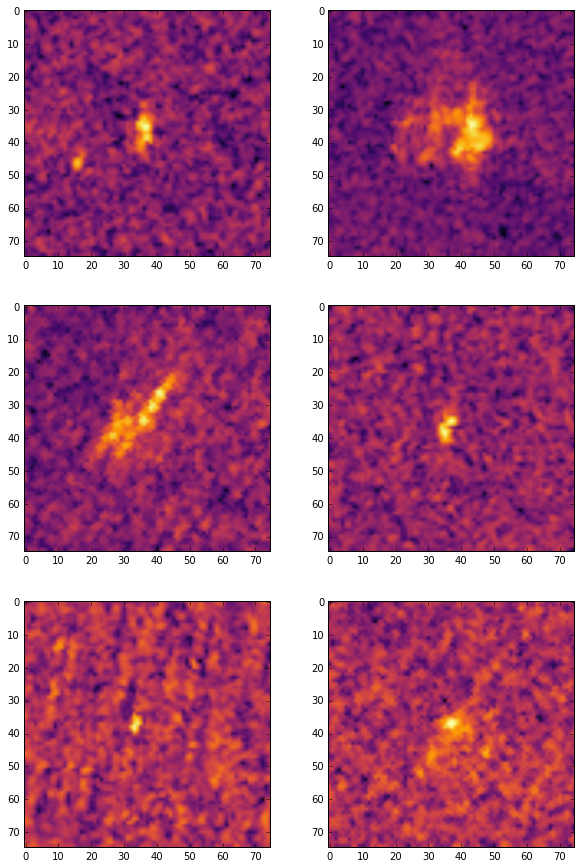

In [16]:
# icebergs in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The second set shows ships in band_1.

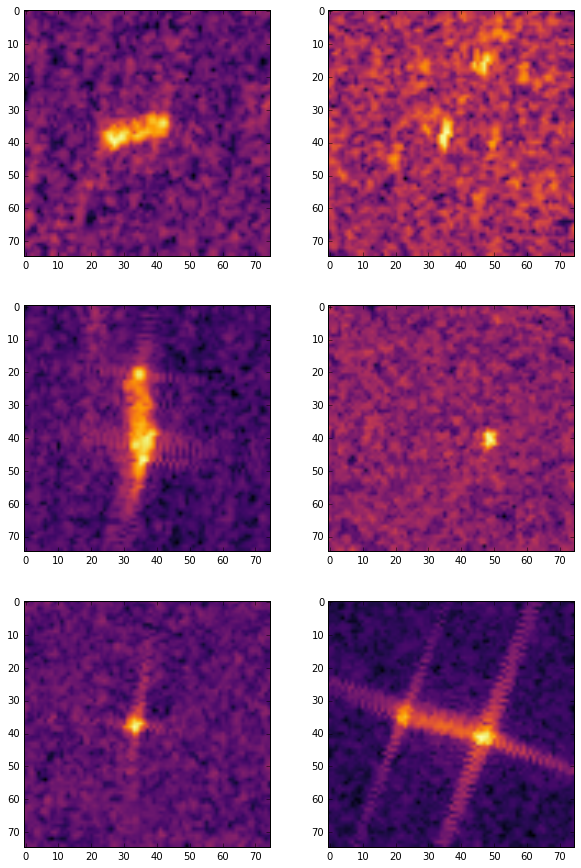

In [17]:
# ships in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

From images above, it's intuitive to tell that the major difference between images of ships and icebergs are images of ships are
spatially continuous while those of icebergs are not.

Similar trend were found in band_2.
Below are images of icebergs show in band_2

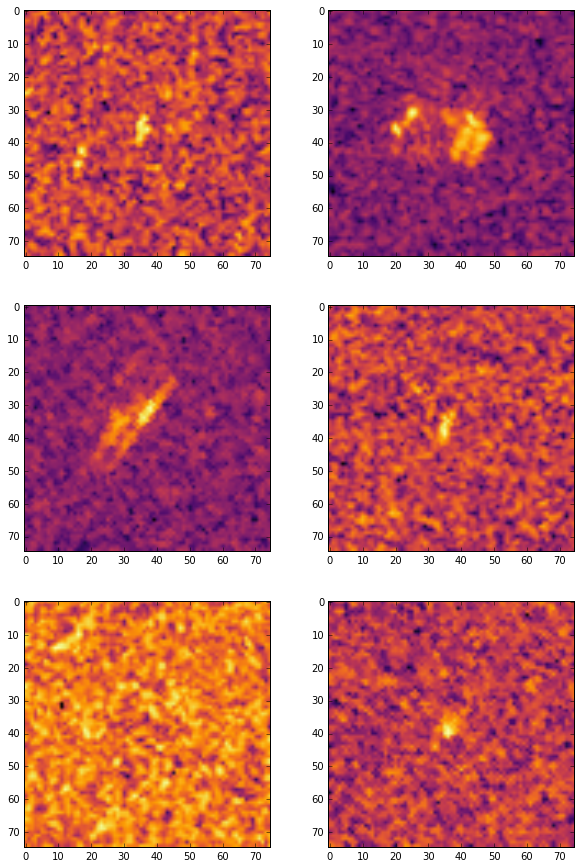

In [18]:
# icebergs in band_2
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

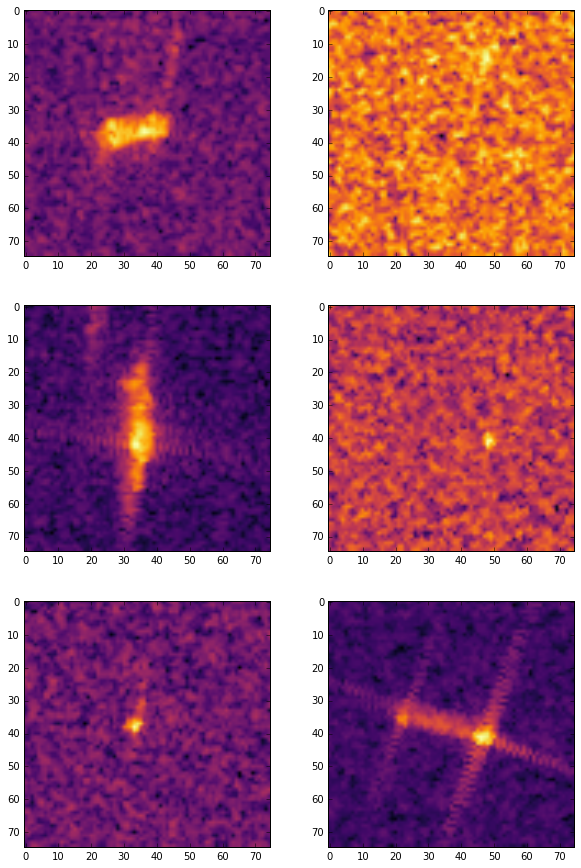

In [19]:
# ships in band_2
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

#### 3.3 Transforming the Images using scipy convolve2d function
Credit to Jian Wang for some of the following code
- The convolve2d requires two input, therefore we need to define the kernel here. 
- The following is just one option of the kernels and there's much left to do to refine the kernels.
- Only images in band_1 are presented here for simplicity. Same rules can be applied to images in band_2.

In [20]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])

#### 3.3.1 Smoothing
The kernel here just has all positive values and is symmetric in both directions.

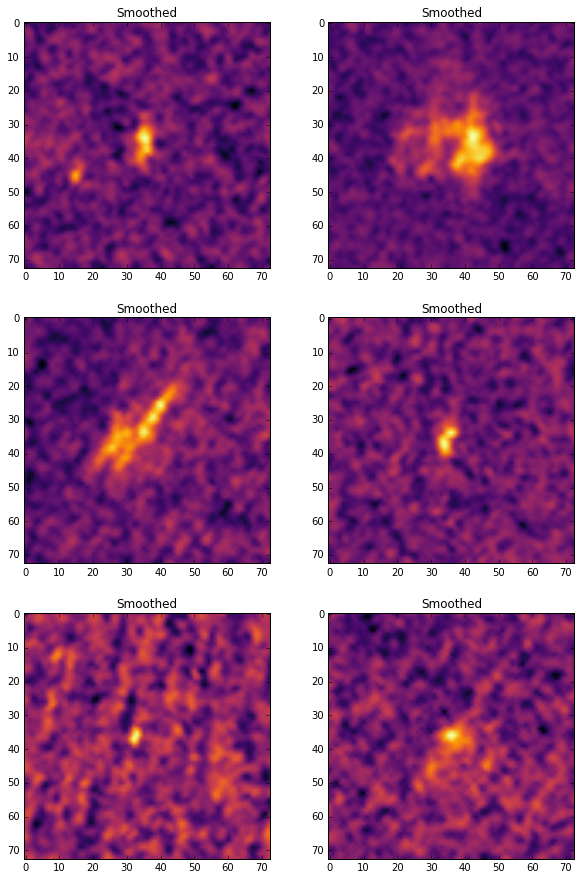

In [21]:
# icebergs in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

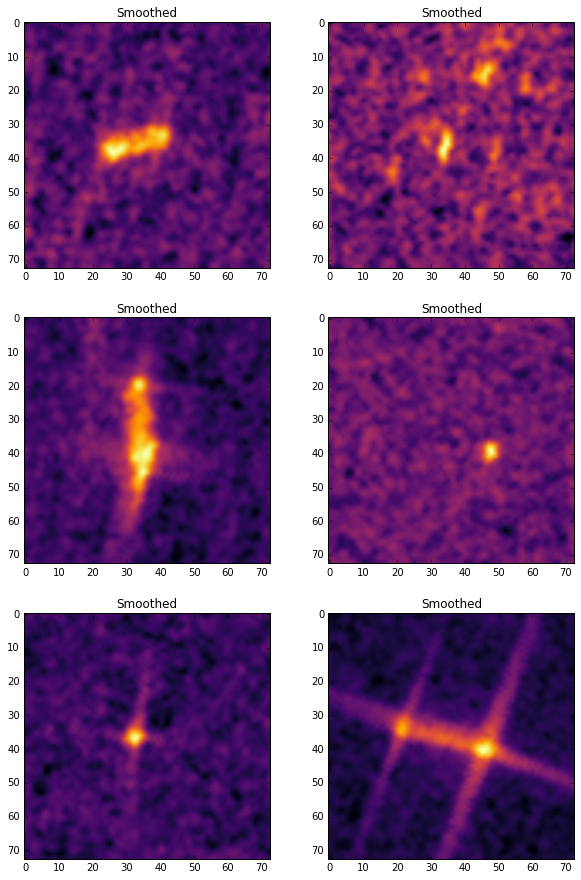

In [22]:
# ships in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

Smoothing blurs the features but also enhance the contrast. Not sure how useful this would be to our model.

#### 3.3.2 Derivative with Respect to X
An X-derivative will typically be antisymmetric with respect to reversing the values around the x-axis. 
This will provide some level of edge detection in the x-direction. I will take the derivatives of the original images.

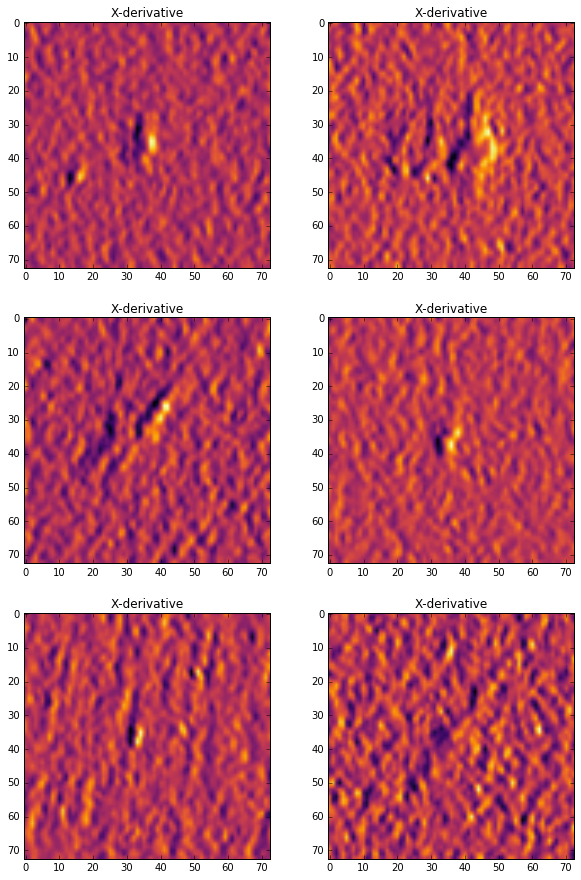

In [23]:
# icebergs in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

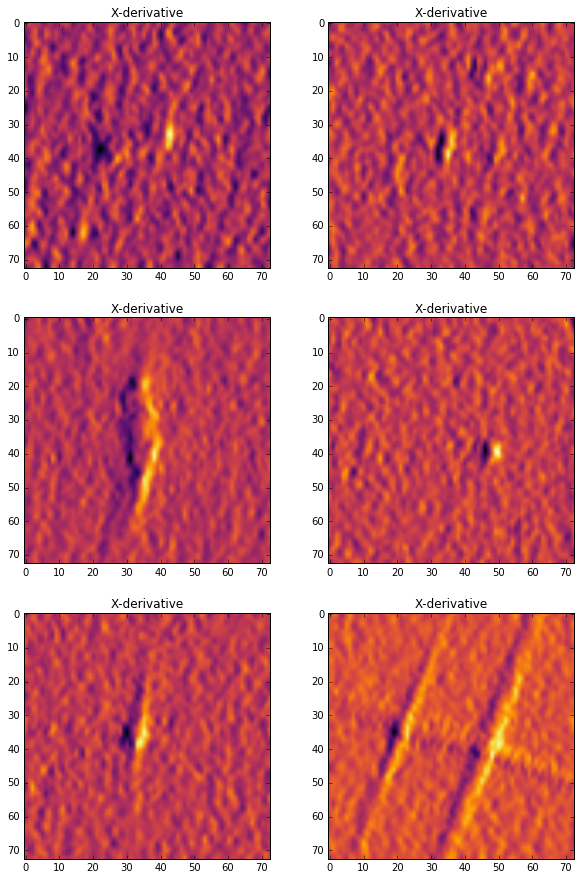

In [24]:
# Ships in band_1
fig = plt.figure(1,figsize=(10,15))
for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

Contrasts at the edges of the objects are enhanced by taking derivative. Not sure how much more information this is adding to
the images though.

#### 3.4 Since we can not get much information simply by visualizing the images, let's look into image statistics (including minimum, maximum, mean and median values) to see how different are the images for the icebergs and ships.

In [25]:
def get_stats(train,label):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)]]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)]]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)]]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)]]
    return train

In [26]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

Histograms of boat and iceberg images in band_1

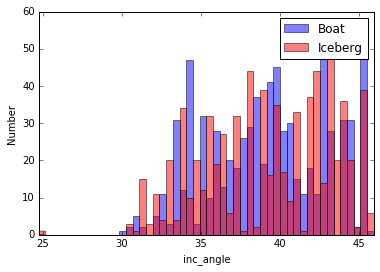

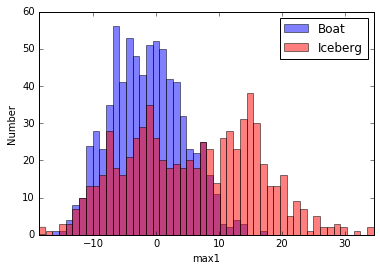

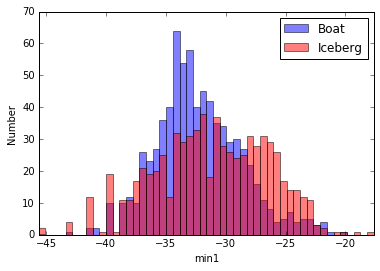

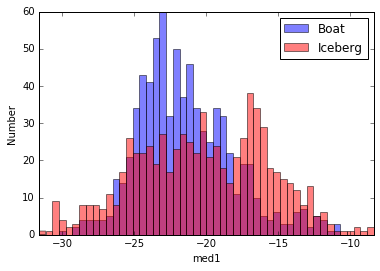

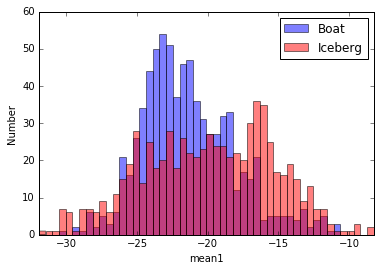

In [27]:
train = get_stats(train, 1)
for col in ['inc_angle','max1','min1','med1','mean1']:
    plot_var(col)

For band_1, the distribution of minimum, maximum, median, and mean are all wider and bigger in for the iceberg than boat. This
information may indicate that signals from the boat are more consistent compared to that from iceberg and the former is smaller
than the latter on average.

Histograms of boat and iceberg images in band_2

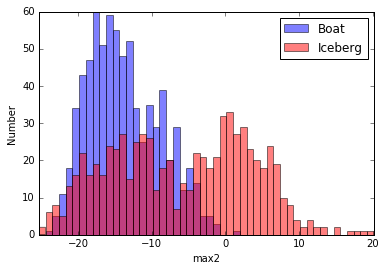

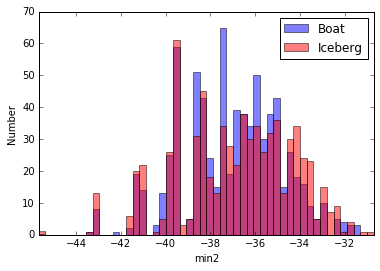

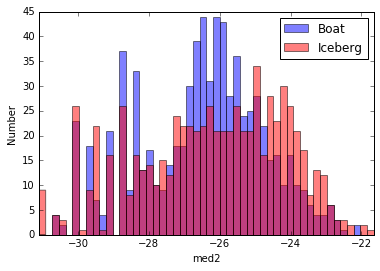

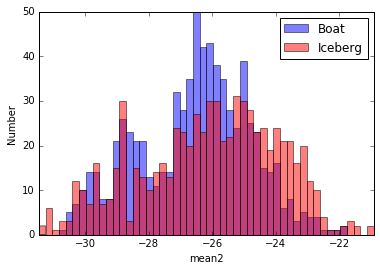

In [28]:
train = get_stats(train, 2)
for col in ['max2','min2','med2','mean2']:
    plot_var(col)

For band_2, similar trend is observed on the max value while difference on the min, medium and mean of the images from the iceberg
and the boat are relatively small.

### Below are the summary from the above analysis:
- The training dataset contains only 1604 entries while the testing dataset contains 8424 entries. Thus, the lack of training dataset may be a big problem. We probably need to use data augmentation to get more training data.
- The major difference between the images of the icebergs and ships are
    - The images of the ships are visually more continuous. 
    - The intensity of the images of the ships are slightly narrowly distributed.
    - The intensity of the images of the ships have slightly smaller max value compared to that of icebergs.
- We are not sure how much information will data transformation add into the data.